In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
import math
import random

np.random.seed(42)

def add_noise_with_r2(fx, epsilon):
    """
    Adds noise to fx such that 1 - R^2 = epsilon.
    
    Parameters:
        fx: array-like, clean function output
        epsilon: desired 1 - R^2 (e.g., 0.2 for R^2 = 0.8)
        random_seed: for reproducibility
        
    Returns:
        y_noisy: fx + noise
    """
    # Variance of the clean signal
    var_fx = np.var(fx)

    # Compute noise variance to achieve desired R^2
    var_noise = (epsilon / (1 - epsilon)) * var_fx

    # Generate zero-mean Gaussian noise with that variance
    noise = np.random.normal(0, np.sqrt(var_noise), size=len(fx))

    return fx + noise


def generate_noisy_relationship(start, end, n, y_func, noise_eps=0.1, inverse_xy=False, normalize=False, f_str=None):
    if f_str is None:
        f_str = 'f(x)'
    x = np.linspace(start, end, n, dtype=np.int32)
    y_clean = y_func(x)
    y_noisy = add_noise_with_r2(y_clean, noise_eps)

    # normalize 
    if normalize:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
        y_clean = (y_clean - np.min(y_clean)) / (np.max(y_clean) - np.min(y_clean))
        y_noisy = (y_noisy - np.min(y_noisy)) / (np.max(y_noisy) - np.min(y_noisy))
        
    return x, y_clean, y_noisy


In [496]:
import numpy as np
from sklearn.utils import shuffle

def entropy_mle(counts):
    total = np.sum(counts)
    probs = counts / total
    probs = probs[probs > 0]  # Avoid log(0)
    return -np.sum(probs * np.log(probs))

def mutual_information_mle(X, Y, bins=10):
    X = np.asarray(X)
    Y = np.asarray(Y)

    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if Y.ndim != 1:
        raise ValueError("Y must be a 1D array")

    joint_data = np.column_stack((X, Y))
    joint_hist, _ = np.histogramdd(joint_data, bins=[bins] * (X.shape[1] + 1))
    hist_X, _ = np.histogramdd(X, bins=[bins] * X.shape[1])
    hist_Y, _ = np.histogram(Y, bins=bins)

    H_X = entropy_mle(hist_X)
    H_Y = entropy_mle(hist_Y)
    H_XY = entropy_mle(joint_hist)

    I_XY = H_X + H_Y - H_XY
    return I_XY, H_Y


def entropy_smoothed(probs):
    probs = probs[probs > 0]
    return -np.sum(probs * np.log(probs))

def mutual_information_mle_smoothed(X, Y, bins=10, alpha=1e-5):
    X = np.asarray(X)
    Y = np.asarray(Y)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    joint_data = np.column_stack((X, Y))
    joint_hist, edges = np.histogramdd(joint_data, bins=[bins] * (X.shape[1] + 1))
    joint_hist_smoothed = joint_hist + alpha
    joint_probs = joint_hist_smoothed / np.sum(joint_hist_smoothed)

    p_x = np.sum(joint_probs, axis=-1)  # sum over Y
    p_y = np.sum(joint_probs, axis=tuple(range(joint_probs.ndim - 1)))  # sum over X dims

    H_X = entropy_smoothed(p_x)
    H_Y = entropy_smoothed(p_y)
    H_XY = entropy_smoothed(joint_probs.flatten())

    return H_X + H_Y - H_XY, H_Y

def reliable_fraction_of_information_smoothed(X, Y, bins=10, alpha=1e-5, n_shuffles=10, random_state=None):
    mi_actual, H_Y = mutual_information_mle_smoothed(X, Y, bins=bins, alpha=alpha)
    mi_shuffled = []
    for _ in range(n_shuffles):
        Y_perm = shuffle(Y, random_state=random_state)
        mi_perm, _ = mutual_information_mle_smoothed(X, Y_perm, bins=bins, alpha=alpha)
        mi_shuffled.append(mi_perm)

    bias = np.mean(mi_shuffled)
    rfi = max(0.0, (mi_actual - bias) / H_Y) if H_Y > 0 else 0.0
    return rfi

def permutations_mi_mle(X, Y, bins=10, n_shuffles=100, seed=None):
    perms = np.zeros(n_shuffles)
    for i in range(n_shuffles):
        Y_perm = shuffle(Y, random_state=seed*n_shuffles + i if seed is not None else None)
        mi = mutual_information_mle(X, Y_perm, bins=bins)[0]
        perms[i] = mi
    return perms

def reliable_fraction_of_information_max(X, Y, bins=10, n_shuffles=100, seed=None):
    I_xy, H_y = mutual_information_mle(X, Y, bins=bins)
    permutations_mi = permutations_mi_mle(X, Y, bins=bins, n_shuffles=n_shuffles, seed=seed)
    bias = np.max(permutations_mi)
    if H_y == 0:
        return 0.0
    rfi = max(0.0, (I_xy - bias) / H_y) if H_y > 0 else 0.0
    return rfi


def reliable_fraction_of_information_exp(X, Y, bins=10, n_shuffles=100, seed=None):
    I_xy, H_y = mutual_information_mle(X, Y, bins=bins)
    permutations_mi = permutations_mi_mle(X, Y, bins=bins, n_shuffles=n_shuffles, seed=seed)
    bias = np.mean(permutations_mi)
    if H_y == 0:
        return 0.0
    rfi = max(0.0, (I_xy - bias) / H_y) if H_y > 0 else 0.0
    return rfi


In [538]:

start = -9.999
end = 9.999
n = 20
ns = [20, 100]

rand = lambda x: np.random.randint(0, 100, size=x.shape[0])
sqr = lambda x: x*x
lin = lambda x: x
sin = lambda x: np.sin(x/2)
mod = lambda x: x % 10
sqrt = lambda x: np.sqrt(x)
cubic = lambda x: x**3
step = lambda x: np.where(x > 0, 1, 0)

funcs = [sqr, lin, mod, rand, sin, cubic, step]
funcs_str = ['square', 'linear', 'modular', 'random', 'sin', 'cubic', 'step']


alpha = 0.5
noise_eps = 0.4
n_shuffles = 100
experiment_len = 50

Number of samples: 20, Bins: 6, Noise epsilon: 0.4, 
Alpha: 0.5, Experiment length: 50, Shuffles (permutations): 100
Function: square
Mutual Information Smoothed: 0.175 nats
Fraction of Information: 0.51
Reliable (Expect) Fraction of Information: 0.072
Reliable (Max) Fraction of Information: 0.0
Fraction of Information Smoothed: 0.102
Pearson Correlation Coefficient: -0.129


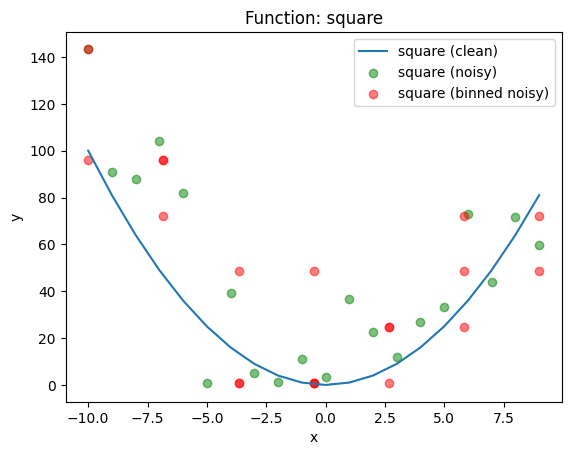

Function: linear
Mutual Information Smoothed: 0.485 nats
Fraction of Information: 1.0
Reliable (Expect) Fraction of Information: 0.566
Reliable (Max) Fraction of Information: 0.407
Fraction of Information Smoothed: 0.271
Pearson Correlation Coefficient: 0.796


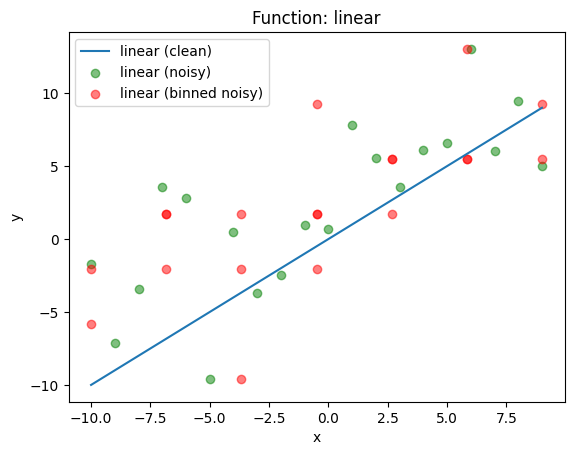

Function: modular
Mutual Information Smoothed: 0.221 nats
Fraction of Information: 0.544
Reliable (Expect) Fraction of Information: 0.112
Reliable (Max) Fraction of Information: 0.0
Fraction of Information Smoothed: 0.124
Pearson Correlation Coefficient: 0.409


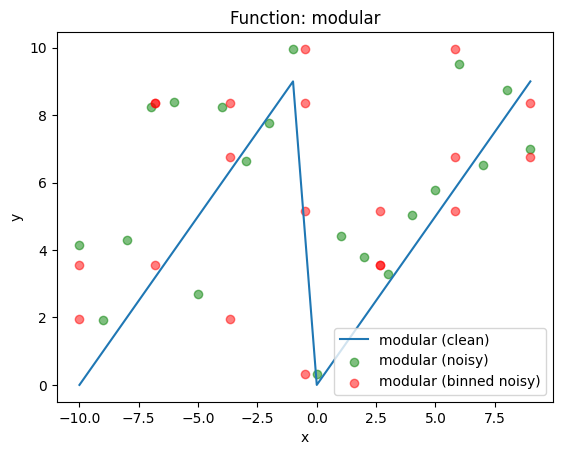

Function: random
Mutual Information Smoothed: 0.15 nats
Fraction of Information: 0.415
Reliable (Expect) Fraction of Information: 0.016
Reliable (Max) Fraction of Information: 0.001
Fraction of Information Smoothed: 0.086
Pearson Correlation Coefficient: -0.037


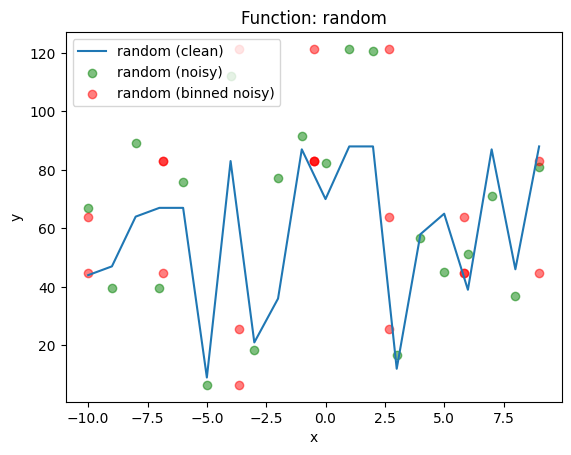

Function: sin
Mutual Information Smoothed: 0.188 nats
Fraction of Information: 0.492
Reliable (Expect) Fraction of Information: 0.065
Reliable (Max) Fraction of Information: 0.0
Fraction of Information Smoothed: 0.107
Pearson Correlation Coefficient: -0.155


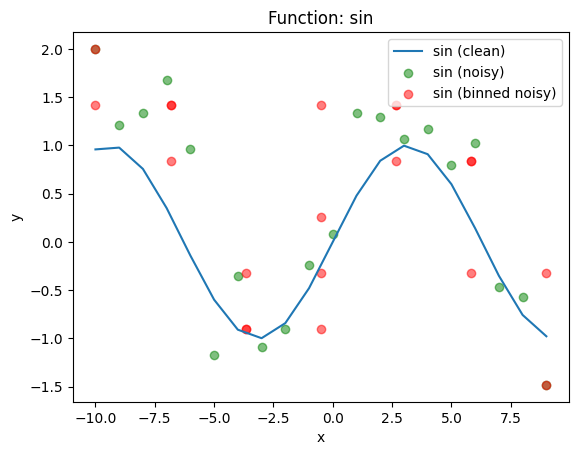

Function: cubic
Mutual Information Smoothed: 0.222 nats
Fraction of Information: 0.684
Reliable (Expect) Fraction of Information: 0.231
Reliable (Max) Fraction of Information: 0.069
Fraction of Information Smoothed: 0.133
Pearson Correlation Coefficient: 0.739


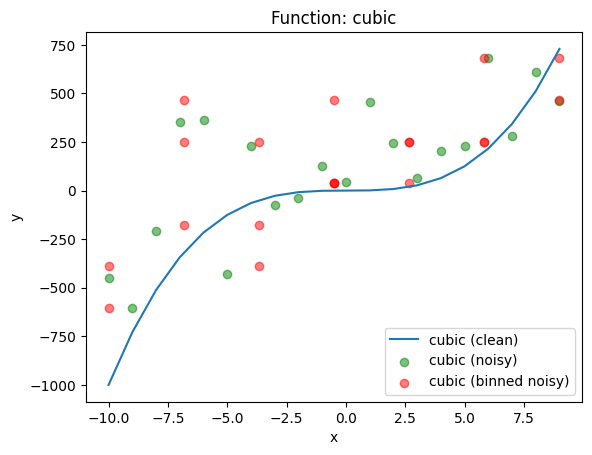

Function: step
Mutual Information Smoothed: 0.199 nats
Fraction of Information: 0.861
Reliable (Expect) Fraction of Information: 0.624
Reliable (Max) Fraction of Information: 0.208
Fraction of Information Smoothed: 0.13
Pearson Correlation Coefficient: 0.691


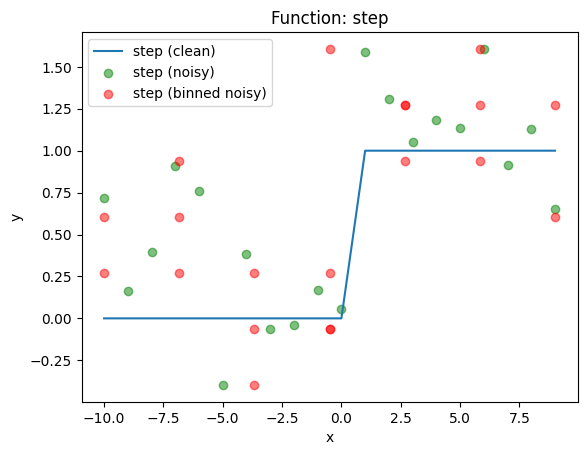

Number of samples: 100, Bins: 8, Noise epsilon: 0.4, 
Alpha: 0.5, Experiment length: 50, Shuffles (permutations): 100
Function: square
Mutual Information Smoothed: 0.571 nats
Fraction of Information: 0.626
Reliable (Expect) Fraction of Information: 0.484
Reliable (Max) Fraction of Information: 0.415
Fraction of Information Smoothed: 0.299
Pearson Correlation Coefficient: -0.14


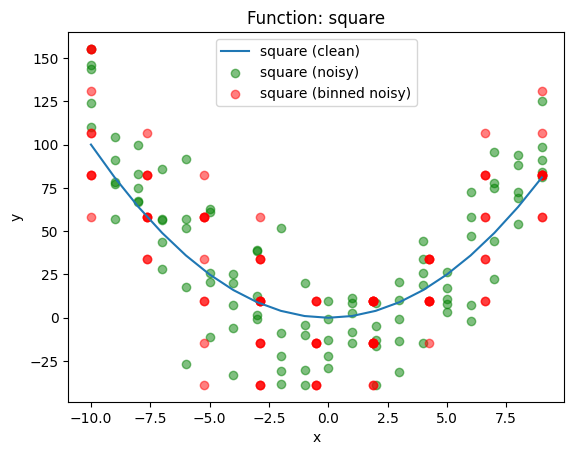

Function: linear
Mutual Information Smoothed: 1.142 nats
Fraction of Information: 1.0
Reliable (Expect) Fraction of Information: 0.856
Reliable (Max) Fraction of Information: 0.792
Fraction of Information Smoothed: 0.552
Pearson Correlation Coefficient: 0.776


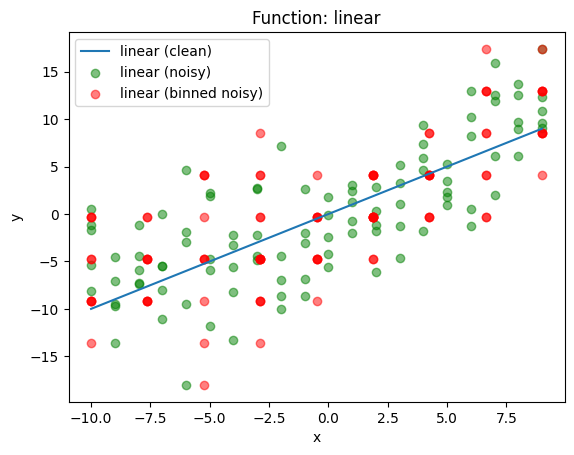

Function: modular
Mutual Information Smoothed: 0.707 nats
Fraction of Information: 0.675
Reliable (Expect) Fraction of Information: 0.528
Reliable (Max) Fraction of Information: 0.462
Fraction of Information Smoothed: 0.345
Pearson Correlation Coefficient: 0.394


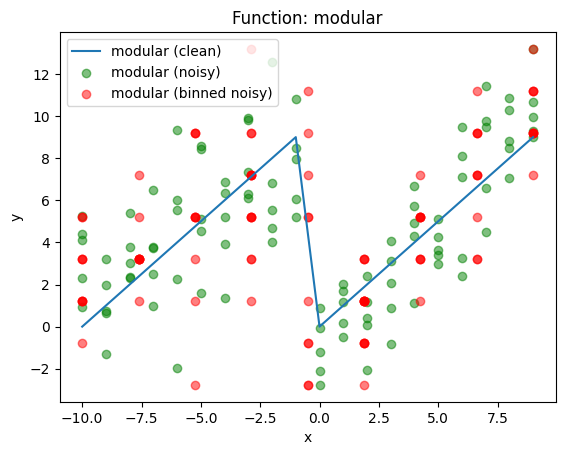

Function: random
Mutual Information Smoothed: 0.136 nats
Fraction of Information: 0.14
Reliable (Expect) Fraction of Information: 0.007
Reliable (Max) Fraction of Information: 0.0
Fraction of Information Smoothed: 0.066
Pearson Correlation Coefficient: 0.001


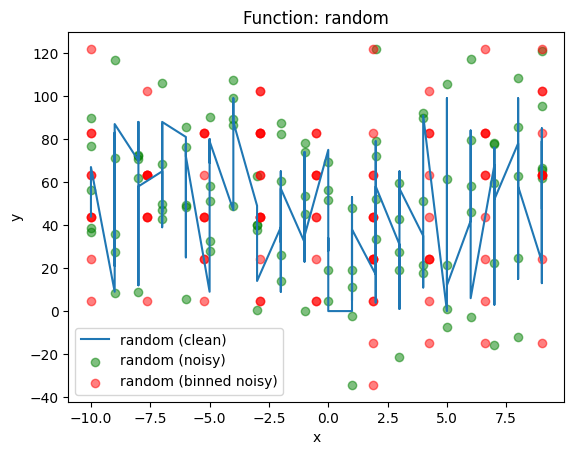

Function: sin
Mutual Information Smoothed: 0.727 nats
Fraction of Information: 0.747
Reliable (Expect) Fraction of Information: 0.592
Reliable (Max) Fraction of Information: 0.524
Fraction of Information Smoothed: 0.374
Pearson Correlation Coefficient: -0.162


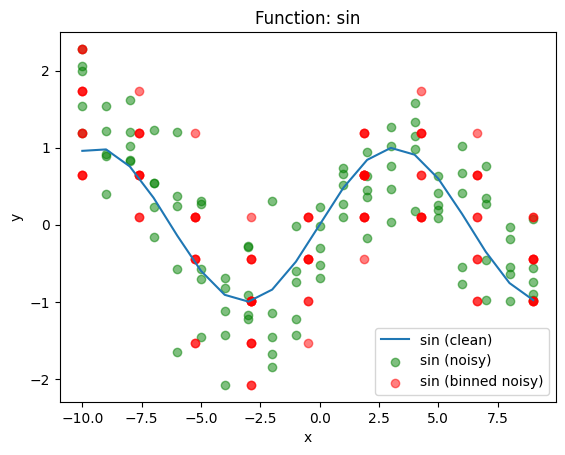

Function: cubic
Mutual Information Smoothed: 0.721 nats
Fraction of Information: 0.841
Reliable (Expect) Fraction of Information: 0.666
Reliable (Max) Fraction of Information: 0.597
Fraction of Information Smoothed: 0.398
Pearson Correlation Coefficient: 0.711


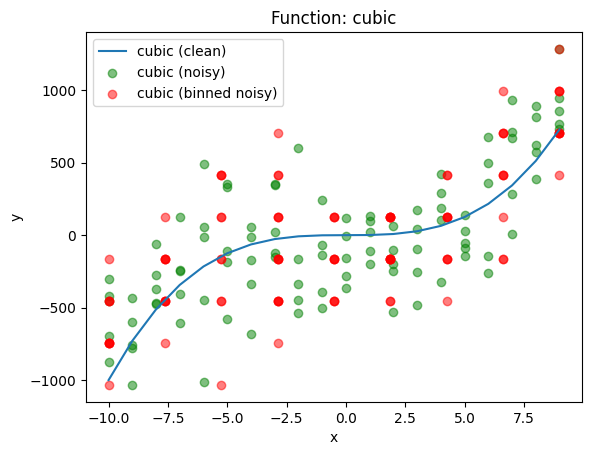

Function: step
Mutual Information Smoothed: 0.395 nats
Fraction of Information: 0.899
Reliable (Expect) Fraction of Information: 0.846
Reliable (Max) Fraction of Information: 0.747
Fraction of Information Smoothed: 0.29
Pearson Correlation Coefficient: 0.667


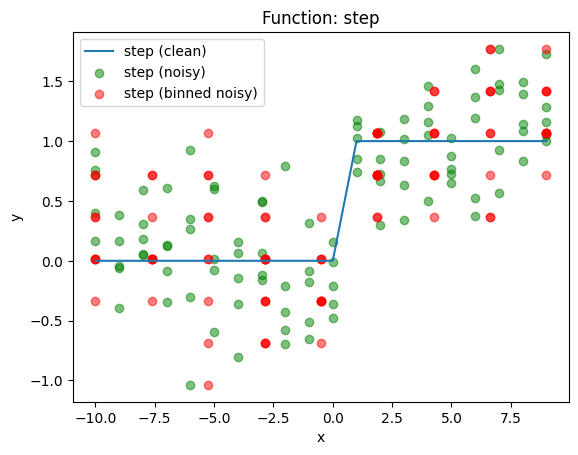

In [539]:

results_dict = {}
for n in ns:
    bins = math.ceil(math.log2(n) + 1)
    print(f"Number of samples: {n}, Bins: {bins}, Noise epsilon: {noise_eps}, \nAlpha: {alpha}, Experiment length: {experiment_len}, Shuffles (permutations): {n_shuffles}")
    plt.figure()
    for func, name in zip(funcs, funcs_str):
        avg_mi = [0.0, 0.0]
        avg_mis = [0.0, 0.0]
        avg_rfi_exp = 0.0
        avg_rfi_max = 0.0
        avg_cor = 0.0
        for i in range(experiment_len):
            np.random.seed(i)
            x, y, y_noisy = generate_noisy_relationship(start, end, n, func, noise_eps=noise_eps)
            mi = mutual_information_mle(x, y, bins=bins)
            mis = mutual_information_mle_smoothed(x, y, bins=bins, alpha=alpha)
            rfi_exp = reliable_fraction_of_information_exp(x, y, bins=bins, n_shuffles=n_shuffles, seed=i)
            rfi_max = reliable_fraction_of_information_max(x, y, bins=bins, n_shuffles=n_shuffles, seed=i)
            avg_rfi_exp += rfi_exp
            avg_rfi_max += rfi_max
            avg_mi[0] += mi[0]
            avg_mi[1] += mi[1]
            avg_mis[0] += mis[0]
            avg_mis[1] += mis[1]
            avg_cor += np.corrcoef(x, y_noisy)[0, 1]
            if i == 0:
                plt.plot(x, y, label=f"{name} (clean)")
                #plot binned data
                plt.scatter(x, y_noisy, label=f"{name} (noisy)", alpha=alpha, color='green')
                # clip x values according to the nearest bin
                hist_x, bins_x = np.histogram(x, bins=bins)
                hist_y, bins_y = np.histogram(y_noisy, bins=bins)
                x = np.vectorize(lambda curx: min(bins_x, key = lambda cur_bin: np.abs(cur_bin-curx)))(x)
                # print(np.unique(x, return_counts=True)[1])
                # assert np.equal(sorted(np.unique(x, return_counts=True)[1]), sorted(hist_x)), "Binned x values do not match histogram"
                y_noisy = np.vectorize(lambda cury: min(bins_y, key = lambda cur_bin: np.abs(cur_bin-cury)))(y_noisy)
                plt.scatter(x, y_noisy, label=f"{name} (binned noisy)", alpha=alpha, color='red')
                plt.xlabel('x')
                plt.ylabel('y')
                plt.legend()
                plt.title(f"Function: {name}")
        avg_mi[0] = avg_mi[0] / experiment_len
        avg_mi[1] = avg_mi[1] / experiment_len
        avg_mis[0] = avg_mis[0] / experiment_len
        avg_mis[1] = avg_mis[1] / experiment_len
        avg_rfi_exp /= experiment_len
        avg_rfi_max /= experiment_len
        avg_cor /= experiment_len

        np.random.seed(42)
        if results_dict.get(n) is None:
            results_dict[n] = {}
        cur_res_dict = results_dict[n]
        print(f"Function: {name}")
        if cur_res_dict.get('MIS') is None:
            cur_res_dict['MIS'] = []
        cur_res_dict['MIS'].append(avg_mis[0])
        if cur_res_dict.get('FI') is None:
            cur_res_dict['FI'] = []
        cur_res_dict['FI'].append(avg_mi[0]/ avg_mi[1])
        if cur_res_dict.get('RFI_EXP') is None:
            cur_res_dict['RFI_EXP'] = []
        cur_res_dict['RFI_EXP'].append(avg_rfi_exp)
        if cur_res_dict.get('RFI_MAX') is None:
            cur_res_dict['RFI_MAX'] = []
        cur_res_dict['RFI_MAX'].append(avg_rfi_max)
        if cur_res_dict.get('FIS') is None:
            cur_res_dict['FIS'] = []
        cur_res_dict['FIS'].append(avg_mis[0] / avg_mis[1])
        if cur_res_dict.get('COR') is None:
            cur_res_dict['COR'] = []
        cur_res_dict['COR'].append(avg_cor)
        print("Mutual Information Smoothed:", round
        (avg_mis[0], 3), "nats")
        print("Fraction of Information:", round(avg_mi[0] / avg_mi[1], 3))
        print("Reliable (Expect) Fraction of Information:", round(avg_rfi_exp, 3))
        print("Reliable (Max) Fraction of Information:", round(avg_rfi_max, 3))
        print("Fraction of Information Smoothed:", round(avg_mis[0] / avg_mis[1], 3))
        print("Pearson Correlation Coefficient:", round(avg_cor, 3))
        plt.show()

In [540]:
eps04_results = results_dict

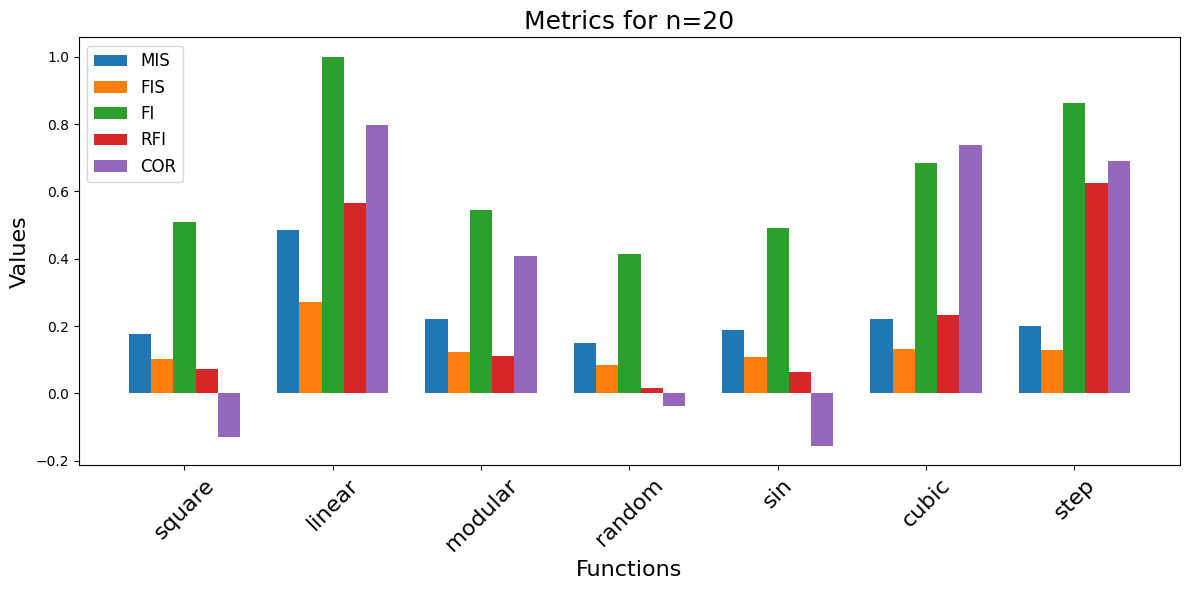

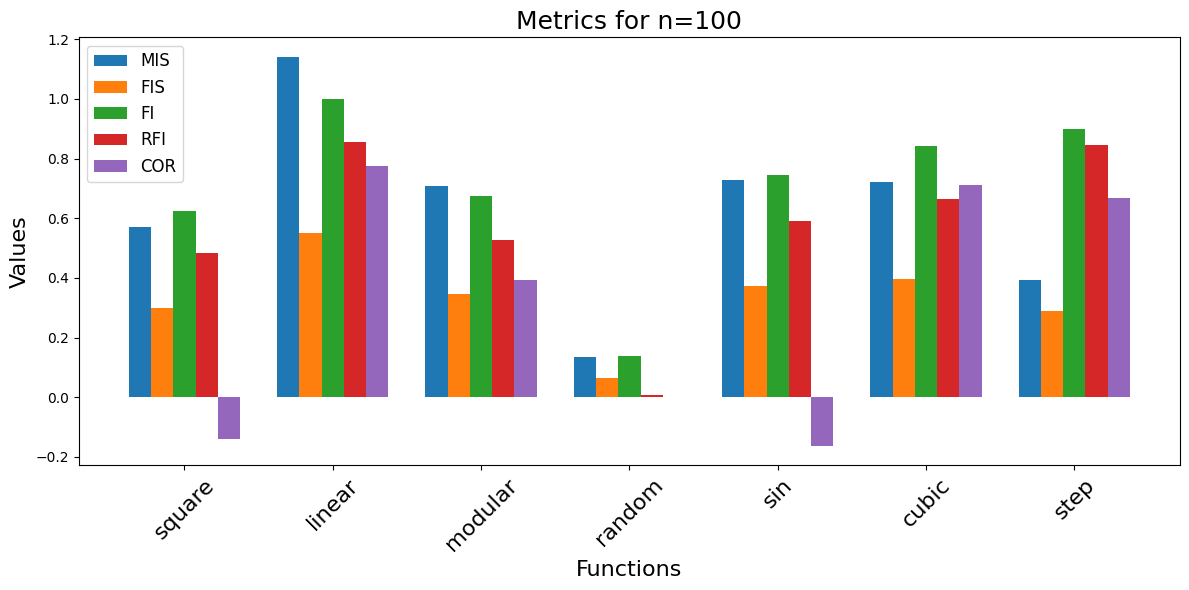

In [541]:
# plot results as grouped bar chart for a certain n value on the x axis different functions, on the y axis the values of the metrics, grouped by the metric type
def plot_results(results, n):
    metrics = ['MIS', 'FIS', 'FI', 'RFI_EXP', 'COR']
    metrics_str = ['MIS', 'FIS', 'FI', 'RFI', 'COR']
    x = np.arange(len(results['MIS']))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, results[metric], width, label=metrics_str[i])

    ax.set_xlabel('Functions', fontsize=16)
    ax.set_ylabel('Values', fontsize=16)
    ax.set_title(f'Metrics for n={n}', fontsize=18)
    ax.set_xticks(x + width * (len(metrics) - 1) / 2)
    ax.set_xticklabels(funcs_str, size=16, rotation=45)
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

plot_results(results_dict[20], 20)
plot_results(results_dict[100], 100)